In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import math

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from functions import grangerTests, plot_seasonal_decompose, daySignal, addDateParts

In [2]:
#define the ticker symbol
tickerSymbol = 'ETH-USD' #'MSFT'

# Date period
start = dt.datetime(2010,1,1)
end = dt.datetime.now()

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
#get the historical prices for this ticker
df = tickerData.history(period='1D', start=start, end=end)

# Removing features with constant values
df = df.loc[:,df.apply(pd.Series.nunique) != 1]

# Some calculated variables
df['day_change'] = df['Close'] - df['Open']
df['day_change_pct'] = (df['day_change'] / df['Open']) * 100
df['day_change_signal'] = df['day_change'].apply(daySignal)

# Lagging close, high and low by one day
for feature in ['Close', 'High', 'Low']:
    df[f"{feature}_lag1"] = df[feature].shift(1).bfill() 

# Adding date features
df = addDateParts(df)

# Exit datetime index
df = df.reset_index()

# View dataframe
df

c:\Users\steph\OneDrive\Documents\GitHub\stock-price-prediction\functions.py:83: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week


,Date,Open,High,Low,Close,Volume,day_change,day_change_pct,day_change_signal,Close_lag1,High_lag1,Low_lag1,day_of_year,day_of_week,week,month
0,2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,12.239014,3.965402,1,320.884003,329.451996,307.056000,9,3,45,11
1,2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,-21.417999,-6.679120,-1,320.884003,329.451996,307.056000,10,4,45,11
2,2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,16.095001,5.390407,1,299.252991,324.717987,294.541992,11,5,45,11
3,2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,-6.782013,-2.155141,-1,314.681000,319.453003,298.191986,12,6,45,11
4,2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,9.691010,3.156424,1,307.907990,319.153015,298.513000,13,0,46,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902,2023-01-24 00:00:00+00:00,1627.848267,1639.723877,1551.389771,1556.604248,8180274691,-71.244019,-4.376576,-1,1628.251099,1641.218140,1607.903076,24,1,4,1
1903,2023-01-25 00:00:00+00:00,1556.807495,1632.241699,1530.797852,1611.711060,10598973448,54.903564,3.526677,1,1556.604248,1639.723877,1551.389771,25,2,4,1
1904,2023-01-26 00:00:00+00:00,1611.080933,1626.198242,1586.598145,1603.105957,8395315241,-7.974976,-0.495008,-1,1611.711060,1632.241699,1530.797852,26,3,4,1
1905,2023-01-27 00:00:00+00:00,1603.080078,1617.000854,1565.244995,1598.156494,8124465373,-4.923584,-0.307133,-1,1603.105957,1626.198242,1586.598145,27,4,4,1


## Pre-processing

https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

In [6]:
close_prices = df[['Date', 'Close']].set_index('Date')
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Preparation of test set

In [10]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## LSTM

In [12]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1466/1466 [==============================] - 46s 28ms/step - loss: 0.0023
Epoch 2/3
1466/1466 [==============================] - 40s 27ms/step - loss: 0.0011
Epoch 3/3
1466/1466 [==============================] - 37s 25ms/step - loss: 8.2015e-04


In [14]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

12/12 [==============================] - 2s 32ms/step


76.21486345426304

In [26]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

print(f" MAPE: {mean_absolute_percentage_error(y_test, predictions)*100}")
print(f" R2: {r2_score(y_test, predictions)*100}")

 MAPE: 4.9335304337512635
 R2: 97.02411200224994


### Visualizing the Predicted Prices

In [18]:
import plotly_express as px

C:\Users\steph\AppData\Local\Temp\ipykernel_15288\101665598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


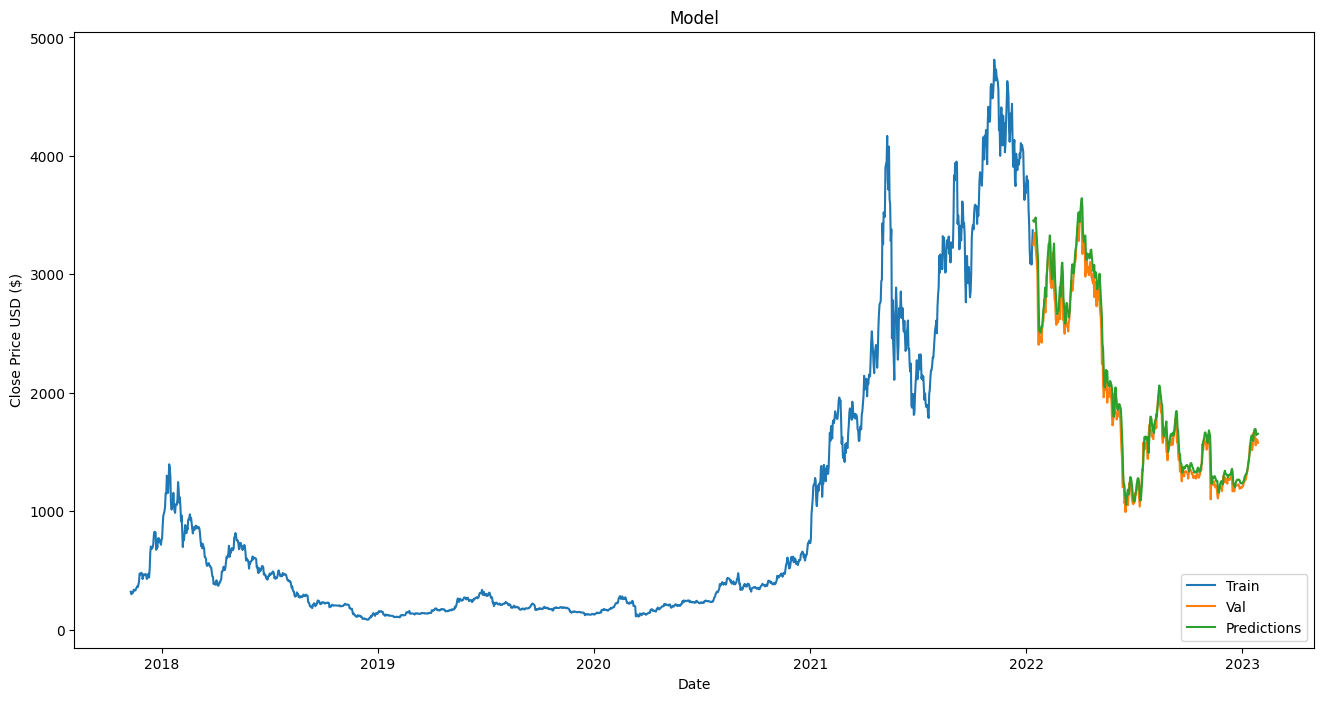

In [20]:
data = df.filter(['Date', 'Close']).set_index('Date')
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()